In [18]:
import zarr 
import numpy as np
import imageio
import os
import random
from skimage.segmentation import relabel_sequential

In [9]:
zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/test.zarr"
root = zarr.open (zarr_path)

In [41]:
test_cond = random.choice (list(root.keys()))
test_image = random.choice (list (root[test_cond].keys()))
test_array = np.array (root[test_cond][test_image]["y"], dtype = "int")
print (test_array.shape)
type (test_array)

(11, 2729, 3637)


numpy.ndarray

In [10]:
def relabel_and_compress (segmentation, start_index = 1):
    for i in range (segmentation.shape[0]):
        if segmentation [i, :, :].max() > 0:
            segmentation [i, :, :] = relabel_sequential (segmentation [i, :, :], offset = start_index)[0]
            start_index = segmentation [i, :, :].max()
        else:
            segmentation [i, :, :] = segmentation [i, :, :]
    segmentation = segmentation.sum (axis = 0)
    return segmentation

def crop_tiles(image, crop_size):
    h, w = image.shape
    h_tiles = (h + crop_size - 1) // crop_size  # ceil division
    v_tiles = (w + crop_size - 1) // crop_size

    # Padding
    pad_h = h_tiles * crop_size - h
    pad_w = v_tiles * crop_size - w
    if pad_h > 0 or pad_w > 0:
        image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')

    # Preallocate output array
    tiles = np.empty((h_tiles * v_tiles, crop_size, crop_size), dtype=image.dtype)

    idx = 0
    for i in range(h_tiles):
        for j in range(v_tiles):
            y_start = i * crop_size
            x_start = j * crop_size
            tiles[idx] = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
            idx += 1

    return tiles


    


In [42]:
for i in range(test_array.shape[0]):
    print (test_array[i, :, :].max())
a = relabel_and_compress (test_array)
print (a.shape)
print (a.max())

b = crop_tiles (a, crop_size = 512)
print (b.shape)

0
16
6
0
6
0
0
0
5
0
957
(2729, 3637)
986
(48, 512, 512)


In [31]:
# print (list (root ["AD"].keys()))
for conditions in list (root.keys()):
    images = root [conditions].keys()
    for fov in images:
        fov_group = root [conditions][fov]
        x = root[conditions][fov] ["x"][:]
        y = root[conditions][fov]["y"][:].astype ("int64")

        y_compressed = relabel_and_compress (y)
        x_cropped = crop_tiles (x, crop_size = 512)
        y_cropped = crop_tiles (y_compressed, crop_size = 512)
        fov_group.create_array (name = "x_cropped", data = x_cropped)
        fov_group.create_array (name = "y_cropped", data = y_cropped)




In [33]:
list(root.keys())
ad_files = list (root ["CBD"].keys())
print (ad_files)
# print (root ["AD"][ad_files[0]]["y"].shape[1:])
for files in ad_files:
    x = root["CBD"][files]["x_cropped"]
    y = root["CBD"][files]["y_cropped"]
    print (x.shape, y.shape)
    if x.shape == y.shape [:]:
        print ("Shapes of X and Y in {files} match")
    else:
        print("Shapes of X and Y in {files} do not match")

['LAMP2_CBD_NA22-198_XY02.tif', 'VPS35_CBD_NA22-198_XY01.tif', 'LAMP2_CBD_NA22-093_XY02.tif', 'VPS35_CBD_NA22-093_XY01.tif', 'GSK3A_CBD_NA22-093_XY01_stitched_overlay.tif', 'FTL_CBD_NA22-298_XY01.tif', 'FTL_CBD_NA15-124_XY02.tif', 'VGF_CBD_NA22-093_XY02.tif', 'GSK3a_CBD_NA22-198_XY03_stitched_overlay.tif', 'LAMP2_CBD_NA22-093_XY01.tif', 'VGF_CBD_NA15-124_XY05.tif', 'LAMP2_CBD_NA22-298_XY06.tif', 'VPS35_CBD_NA15-124_XY01.tif', 'GSK3a_CBD_NA15-124_XY01_stitched_overlay.tif', 'VGF_CBD_NA22-198_XY02.tif', 'FTL_CBD_NA22-093_XY01.tif', 'LAMP2_CBD_NA22-198_XY01.tif']
(48, 512, 512) (48, 512, 512)
Shapes of X and Y in {files} match
(48, 512, 512) (48, 512, 512)
Shapes of X and Y in {files} match
(48, 512, 512) (48, 512, 512)
Shapes of X and Y in {files} match
(48, 512, 512) (48, 512, 512)
Shapes of X and Y in {files} match
(48, 512, 512) (48, 512, 512)
Shapes of X and Y in {files} match
(48, 512, 512) (48, 512, 512)
Shapes of X and Y in {files} match
(48, 512, 512) (48, 512, 512)
Shapes of X a

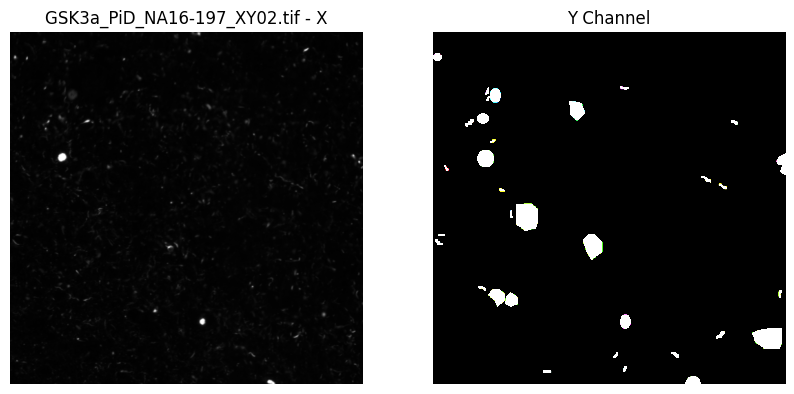

In [114]:
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

    # Randomly pick a condition
condition = random.choice (list (root.keys()))
condition_group = root[condition]
    
    # Randomly pick an image
image_name = random.choice(list(condition_group.keys()))
image_group = condition_group[image_name]
    
    # Access x and y arrays

index = random.choice (range (0,48))
x = image_group["x_cropped"][:] [index, :, :]    
y = image_group["y_cropped"][:] [index, :, :]     

# x = x[index, :, :]
# y = y[index, :, :]
    
np.random.seed(1)
colors = [[0, 0, 0]] + [list(np.random.choice(range(256), size=3)) for _ in range(254)]
label_cmap = ListedColormap(colors)    
    
    # Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(x, cmap="gray")
axes[0].set_title(f"{image_name} - X")
axes[0].axis("off")
    
axes[1].imshow(y, cmap=label_cmap)
axes[1].set_title(f"Y Channel")
axes[1].axis("off")
    
plt.show()